Loading the train dataset

In [2]:
import os
import numpy as np
from sklearn.model_selection import KFold

train_dir = "Lung cancer detection/train"

# Get class names
class_names = sorted(os.listdir(train_dir))  # ["adenocarcinoma", "large_cell_carcinoma", "normal", "squamous_cell_carcinoma"]

# Gather all image paths and labels
image_paths = []
labels = []
for label_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(train_dir, class_name)
    for fname in os.listdir(class_folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_folder, fname))
            labels.append(label_idx)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Total train images:", len(image_paths))
print("Classes:", class_names)


Total train images: 612
Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


This cell defines the preprocessing pipeline and dataset creation functions 

In [3]:
import tensorflow as tf

IMG_SIZE = 256

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),   
    tf.keras.layers.RandomRotation(0.05),      
    tf.keras.layers.RandomZoom(0.05),          
    tf.keras.layers.RandomContrast(0.05),     
])

def parse_image(path, label):
    # Load and decode
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1)  # or channels=1 if truly grayscale
    # Resize
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Scale to [0,1] or do further normalization
    image = image / 255.0
    return image, label

def create_dataset(paths, labs, batch_size=16, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labs))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=42)

    ds = ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    # If augment=True, apply random transformations
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds



Defining class weights and training callbacks to handle class imbalance and optimize the training process

In [ ]:
from tensorflow.keras import layers, models
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

#counts of each class
counts = {
    0: 194,  # adenocarcinoma
    1: 115,  # large cell carcinoma
    2: 148,  # normal
    3: 155   # squamous
}


#diclaration of class weights to maintain the balance
class_weights = {0: 1.0, 1: 2.0, 2: 1.5, 3: 1.4}
print("Class weights:", class_weights)

early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)





Class weights: {0: 1.0, 1: 2.0, 2: 1.5, 3: 1.4}


Building the model

In [6]:
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(4, activation='softmax')  # 4 output classes
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

This cell implements K-Fold Cross-Validation to evaluate the model's performance across multiple splits of the dataset.

In [7]:

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_accuracies = []

for fold_index, (train_idx, val_idx) in enumerate(kf.split(image_paths)):
    print(f"\n=== Fold {fold_index+1}/{k} ===")
    
    # Create the subset for this fold
    fold_train_paths = image_paths[train_idx]
    fold_train_labels = labels[train_idx]
    fold_val_paths = image_paths[val_idx]
    fold_val_labels = labels[val_idx]
    
    # Build TF datasets
    ds_train = create_dataset(fold_train_paths, fold_train_labels, shuffle=True)
    ds_val   = create_dataset(fold_val_paths, fold_val_labels, shuffle=False)
    
    # Build a fresh model for each fold
    model = build_model()
    
    # Train
    history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30,                   # set high enough
    class_weight=class_weights,  # handle imbalance
    callbacks=[early_stopper, lr_reducer]
)
    
    # Evaluate on the fold's validation subset
    val_preds = model.predict(ds_val)
    val_preds = np.argmax(val_preds, axis=1)
    
    fold_acc = accuracy_score(fold_val_labels, val_preds)
    fold_accuracies.append(fold_acc)
    print(f"Fold {fold_index+1} Validation Accuracy: {fold_acc:.4f}")

print("\nCross-validation accuracies:", fold_accuracies)
print("Average CV accuracy:", np.mean(fold_accuracies))



=== Fold 1/5 ===
Epoch 1/30


c:\Users\Ramith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.2998 - loss: 1.9105 - val_accuracy: 0.5122 - val_loss: 1.0807 - learning_rate: 3.0000e-04
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.6536 - loss: 1.2813 - val_accuracy: 0.6179 - val_loss: 1.0459 - learning_rate: 3.0000e-04
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.7575 - loss: 0.7873 - val_accuracy: 0.8049 - val_loss: 0.5895 - learning_rate: 3.0000e-04
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 0.8516 - loss: 0.5071 - val_accuracy: 0.7236 - val_loss: 0.7368 - learning_rate: 3.0000e-04
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.9264 - loss: 0.2777 - val_accuracy: 0.8537 - val_loss: 0.5038 - learning_rate: 3.0000e-04
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9053 - loss: 0.2832 - val_accuracy: 0.8780 - val_loss: 0.4166 - learning_rate: 3.0000e-04
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.9560 - lo

c:\Users\Ramith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.2962 - loss: 2.0076 - val_accuracy: 0.6667 - val_loss: 1.1113 - learning_rate: 3.0000e-04
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.6429 - loss: 1.3307 - val_accuracy: 0.7154 - val_loss: 0.7791 - learning_rate: 3.0000e-04
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.7014 - loss: 0.9207 - val_accuracy: 0.6748 - val_loss: 0.7115 - learning_rate: 3.0000e-04
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.8082 - loss: 0.6375 - val_accuracy: 0.7805 - val_loss: 0.4983 - learning_rate: 3.0000e-04
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.8666 - loss: 0.4494 - val_accuracy: 0.7724 - val_loss: 0.4955 - learning_rate: 3.0000e-04
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.9236 - loss: 0.2474 - val_accuracy: 0.8374 - val_loss: 0.3691 - learning_rate: 3.0000e-04
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.9230 - lo

c:\Users\Ramith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.2840 - loss: 1.9911 - val_accuracy: 0.5000 - val_loss: 0.9722 - learning_rate: 3.0000e-04
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.6129 - loss: 1.2446 - val_accuracy: 0.7623 - val_loss: 0.5770 - learning_rate: 3.0000e-04
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.7814 - loss: 0.7693 - val_accuracy: 0.8607 - val_loss: 0.4149 - learning_rate: 3.0000e-04
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.8661 - loss: 0.5061 - val_accuracy: 0.7787 - val_loss: 0.5663 - learning_rate: 3.0000e-04
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.8585 - loss: 0.4672 - val_accuracy: 0.8852 - val_loss: 0.2602 - learning_rate: 3.0000e-04
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.9444 - loss: 0.2627 - val_accuracy: 0.9016 - val_loss: 0.2413 - learning_rate: 3.0000e-04
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.9605 - lo

c:\Users\Ramith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.2843 - loss: 1.9698 - val_accuracy: 0.6066 - val_loss: 0.9541 - learning_rate: 3.0000e-04
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.5974 - loss: 1.2088 - val_accuracy: 0.7213 - val_loss: 0.6470 - learning_rate: 3.0000e-04
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.7632 - loss: 0.7216 - val_accuracy: 0.8361 - val_loss: 0.4180 - learning_rate: 3.0000e-04
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.8350 - loss: 0.5390 - val_accuracy: 0.8525 - val_loss: 0.4041 - learning_rate: 3.0000e-04
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.9353 - loss: 0.2686 - val_accuracy: 0.8770 - val_loss: 0.3505 - learning_rate: 3.0000e-04
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.9475 - loss: 0.2417 - val_accuracy: 0.8934 - val_loss: 0.3424 - learning_rate: 3.0000e-04
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.9627 - lo

c:\Users\Ramith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 377ms/step - accuracy: 0.2423 - loss: 2.0581 - val_accuracy: 0.5246 - val_loss: 1.0788 - learning_rate: 3.0000e-04
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.5488 - loss: 1.3702 - val_accuracy: 0.7049 - val_loss: 0.6955 - learning_rate: 3.0000e-04
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.7346 - loss: 0.8296 - val_accuracy: 0.7295 - val_loss: 0.6113 - learning_rate: 3.0000e-04
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.7963 - loss: 0.6775 - val_accuracy: 0.7869 - val_loss: 0.5088 - learning_rate: 3.0000e-04
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.8836 - loss: 0.4551 - val_accuracy: 0.8689 - val_loss: 0.3780 - learning_rate: 3.0000e-04
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.9378 - loss: 0.3101 - val_accuracy: 0.8279 - val_loss: 0.4181 - learning_rate: 3.0000e-04
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.9220 - 

Final model training on the full training dataset.

In [8]:
# Creating dataset from ALL train images
ds_full_train = create_dataset(image_paths, labels, shuffle=True,augment=True)

# Building final model
final_model = build_model()

history=final_model.fit(
    ds_full_train,
    epochs=60,  
    verbose=1
)


Epoch 1/60


c:\Users\Ramith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.3473 - loss: 1.3226
Epoch 2/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.6130 - loss: 0.9940
Epoch 3/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.6046 - loss: 0.8923
Epoch 4/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.6894 - loss: 0.7467
Epoch 5/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.7469 - loss: 0.6392
Epoch 6/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.8133 - loss: 0.5294
Epoch 7/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.8131 - loss: 0.4892
Epoch 8/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.8297 - loss: 0.4095
Epoch 9/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.8168 - loss: 0.4594
Epoch 10/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.8532 - loss: 0.4045
Epoch 11/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.8483 - loss: 0.3993
Epoch 12/60
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy

Plotting training loss over epochs

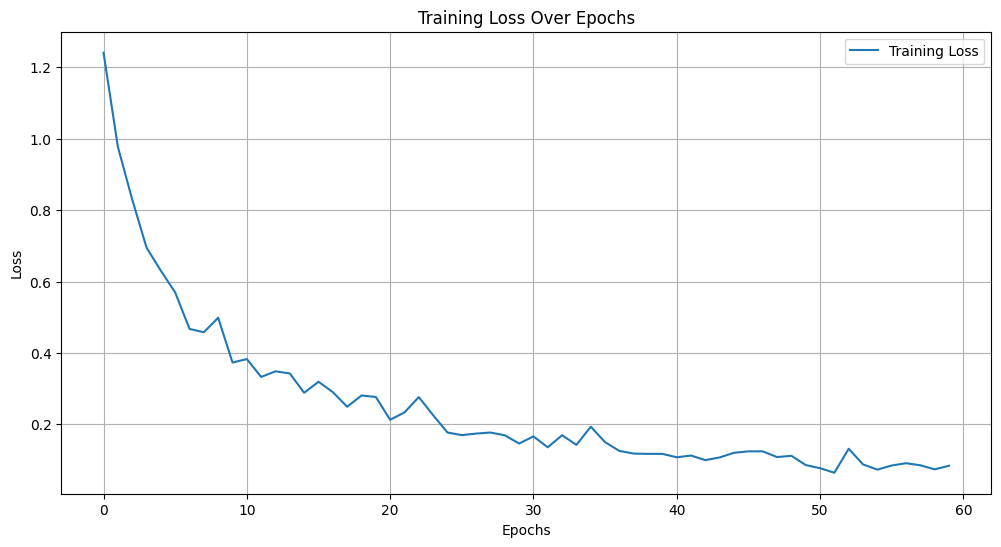

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Saving the final model

In [10]:
final_model.save('macc.keras')